In [ ]:

import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-10-02 08:59:18--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-10-02 08:59:18 (2.84 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



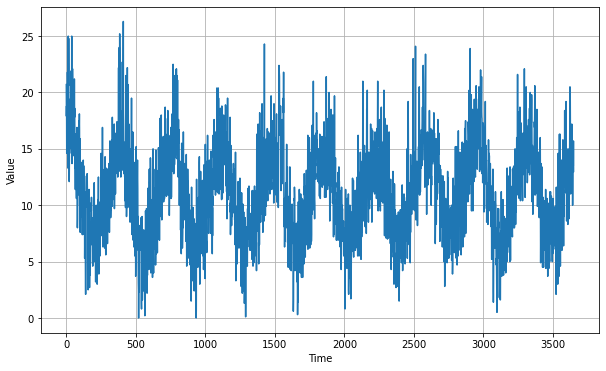

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
series

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional


In [ ]:

tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
                    LSTM(64, return_sequences=True),
                    LSTM(64, return_sequences=True),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1)
])
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

39/39 [==============================] - 0s 12ms/step - loss: 8.0386 - mae: 8.5336
Epoch 2/100
39/39 [==============================] - 0s 11ms/step - loss: 3.2252 - mae: 3.6959
Epoch 3/100
39/39 [==============================] - 0s 12ms/step - loss: 2.8635 - mae: 3.3314
Epoch 4/100
39/39 [==============================] - 0s 11ms/step - loss: 2.7342 - mae: 3.2004
Epoch 5/100
39/39 [==============================] - 0s 13ms/step - loss: 2.2193 - mae: 2.6760
Epoch 6/100
39/39 [==============

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

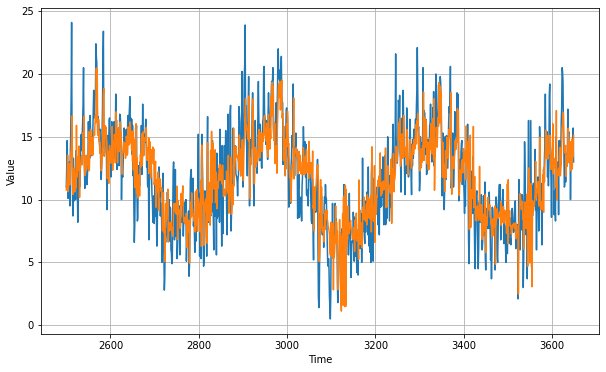

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.9575932